### Take the tile-30-95 as example.


In [1]:
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.transform_xy import geo2imagexy
from utils.crop_to_extent import crop_to_extent
import numpy as np
import h5py


In [48]:
### Tile number determination
extent_bottom, extent_left = 30, 95
year = '2019'
data_type = 'GLAH14' if year in ['2006', '2007', '2008', '2009'] else 'ATL06'
year_lc30 = '2010' if year in ['2006', '2007', '2008', '2009'] else '2020'
print('Icesat data type:', data_type)
print('Globeland30 year:', year_lc30)


Icesat data type: ATL06
Globeland30 year: 2020


### Dem data.

In [35]:
path_srtm = 'data/dem-data/srtm-c/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'.tif'
path_srtm_albers = 'data/dem-data/srtm-c/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'_albers.tif' ## used for area calculation.
srtm, srtm_info = readTiff(path_srtm)
srtm_albers, srtm_albers_info = readTiff(path_srtm_albers)
srtm[srtm<0]=0; srtm_albers[srtm_albers<0]=0
print(srtm.shape, srtm_albers.shape)


(3600, 3600) (4028, 3502)


### Glacier mask

In [36]:
path_glacier = 'data/rgi60/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'.tif'
path_glacier_albers = 'data/rgi60/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'_albers.tif'
mask_glacier = crop_to_extent(path_img=path_glacier, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
mask_glacier_albers = crop_to_extent(path_img=path_glacier_albers, \
                                extent=srtm_albers_info['geoextent'], size_target=srtm_albers.shape) # read and resize
mask_glacier[mask_glacier<0]=0; mask_glacier = np.int8(mask_glacier)
mask_glacier_albers[mask_glacier_albers<0]=0; mask_glacier_albers = np.int8(mask_glacier_albers)
print(mask_glacier.shape, mask_glacier_albers.shape)


(3600, 3600) (4028, 3502)


### Statistic of the glacier area of each 100-m elevation bin (based on the albers projection). 

In [37]:
### Statistic of the glacier area of each 100-m elevation bin.
glacier_area_bins = {}
glacier_area = 0
srtm_glacier = srtm_albers*mask_glacier_albers
srtm_glacier_ = srtm_glacier[srtm_glacier>0]
h_start, h_end = np.nanmin(srtm_glacier_), np.nanmax(srtm_glacier_)
bin_start, bin_end = np.floor(h_start/100)*100, np.ceil(h_end/100)*100
print("bin_start, bin_end: ",bin_start, bin_end)
num_bin = ((bin_end - bin_start)/100).astype(int)
for i in range(num_bin):
  start, end = bin_start + i*100,  bin_start + i*100 + 100
  ids_pixels_bin = np.where((srtm_glacier > start) & (srtm_glacier < end))[0]
  area_pixels_bin = ids_pixels_bin.shape[0]*0.03*0.03   ### the height and width of pixel is 0.03 km
  glacier_area_bins[str(start.astype(int))+'-'+str(end.astype(int))] = area_pixels_bin
  glacier_area += area_pixels_bin
print('overall glacier area (km2):', glacier_area)
print(glacier_area_bins.keys())


bin_start, bin_end:  3200.0 6300.0
overall glacier area (km2): 670.4298
dict_keys(['3200-3300', '3300-3400', '3400-3500', '3500-3600', '3600-3700', '3700-3800', '3800-3900', '3900-4000', '4000-4100', '4100-4200', '4200-4300', '4300-4400', '4400-4500', '4500-4600', '4600-4700', '4700-4800', '4800-4900', '4900-5000', '5000-5100', '5100-5200', '5200-5300', '5300-5400', '5400-5500', '5500-5600', '5600-5700', '5700-5800', '5800-5900', '5900-6000', '6000-6100', '6100-6200', '6200-6300'])


([<matplotlib.axis.XTick at 0x7fc143fc26a0>,
 [Text(1.0, 0, '3200.0'), Text(15.5, 0, '4750.0'), Text(31.0, 0, '6300.0')])

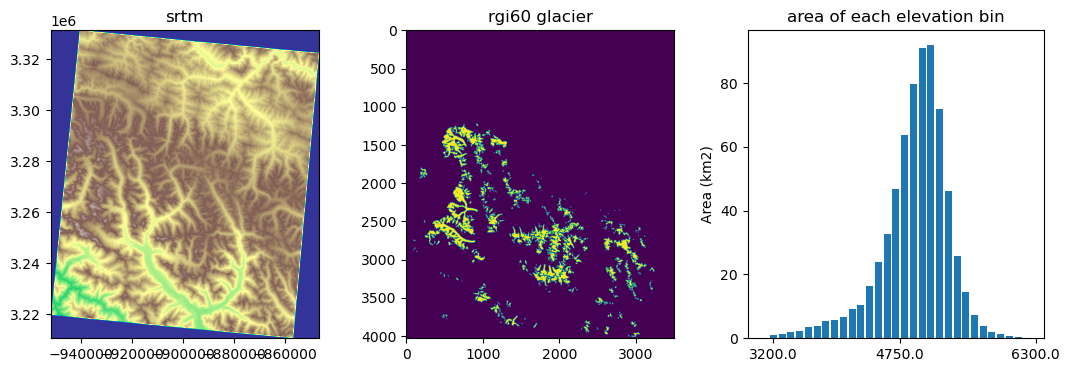

In [38]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
plt.imshow(srtm_albers, vmin=0, vmax=7000, extent=srtm_albers_info['geoextent'], cmap='terrain')
plt.title('srtm')
plt.subplot(1,3,2)
plt.imshow(mask_glacier_albers)
plt.title('rgi60 glacier')
plt.subplot(1,3,3)
num_bins = len(glacier_area_bins.keys())
plt.bar(range(len(glacier_area_bins.keys())), glacier_area_bins.values())
plt.title("area of each elevation bin")
plt.ylabel("Area (km2)")
plt.xticks([1, num_bins/2, num_bins], [str(bin_start), str((bin_end+bin_start)/2), str(bin_end)])


### Water mask

In [39]:
path_wat = 'data/water/water-jrc/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'.tif'
mask_wat = crop_to_extent(path_img=path_wat, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
mask_wat = np.int8(mask_wat)
mask_wat.shape



(3600, 3600)

### Globeland30 data and extract the forest/shrup coverage.

In [49]:
path_gl30 = 'data/globeland30/2020/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'.tif'
gl30 = crop_to_extent(path_img=path_gl30, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
mask_forest = np.where((gl30==20) | (gl30==40), 1, 0)  # extract forest/shrup from the gl30 data
mask_forest.shape


(3600, 3600)

### Read icesat data

In [50]:
data_dir = data_type + '-' + year
tile_dir = 'tile-'+str(extent_bottom)+'-'+str(extent_left)
path_isat = 'data/icesat/' + data_dir + '/' + tile_dir + '/data_readout_merge_subs.h5'
!h5ls $path_isat


beam_type                Dataset {273872}
cycle                    Dataset {273872}
h                        Dataset {273872}
lat                      Dataset {273872}
lon                      Dataset {273872}
orbit_type               Dataset {273872}
rgt                      Dataset {273872}
spot                     Dataset {273872}
t_dyr                    Dataset {273872}


In [51]:
### read icesat-2 data
keys = ['lon', 'lat', 'h', 't_dyr']   ## output variables
isat = {}
for key in keys: 
    isat[key]=np.array([]); 
with h5py.File(path_isat,'r') as f_isat:
    isat['lon'] = f_isat['lon'][:]
    isat['lat'] = f_isat['lat'][:]
    isat['h'] = f_isat['h'][:]
    isat['t_dyr'] = f_isat['t_dyr'][:]
print(isat['lon'].shape)


(273872,)


### Remove icesat data which have no corresponding dem data 

In [52]:
### 1.Remove icesat data which is out of the dem image extent.
lon_min_srtm, lon_max_srtm, lat_min_srtm, lat_max_srtm = srtm_info['geoextent']
ids = np.where((isat['lon']>lon_min_srtm) & (isat['lon']<lon_max_srtm) & (isat['lat']>lat_min_srtm) & (isat['lat']<lat_max_srtm))[0]
## 1. update the isat2 data: remove the icesat2 data which is out of the srtm extent. 
for key in isat:
  isat[key] = isat[key][ids]
## 2. update the isat2 data: filter the icesat2 footprints which have no data on the srtm image.
row_isat_srtm, col_isat_srtm = geo2imagexy(x=isat['lon'], y=isat['lat'], gdal_trans=srtm_info['geotrans'], integer=True)
ids = np.where((srtm[row_isat_srtm, col_isat_srtm] > 0))[0]
for key in isat:
  isat[key] = isat[key][ids]
print(isat['lon'].shape)



(273821,)


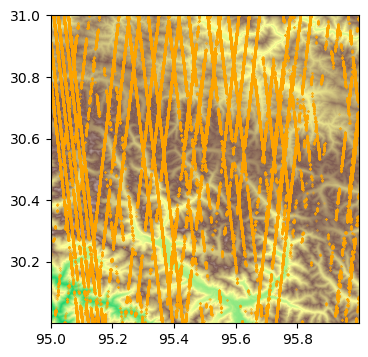

In [53]:
## check isat2 data and srtm
plt.figure(figsize=(4,4))
plt.subplot(1,1,1)
plt.imshow(srtm, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.scatter(x=isat['lon'], y=isat['lat'], marker='.',c='orange', s=0.2, zorder=0)


### Assign footprint type: stable (0), water (1), forest(2), glacier (3). 


In [54]:
isat['type_fp'] = np.zeros_like(isat['lon'])  ## stable type: 0
### water type determination, index number: 1
ids_wat = np.where(mask_wat[row_isat_srtm, col_isat_srtm]==1)[0]
isat['type_fp'][ids_wat]=1
### forest type determination, index number: 2
ids_forest = np.where(mask_forest[row_isat_srtm, col_isat_srtm]==1)[0]
isat['type_fp'][ids_forest]=2
### glacier type determination, index number: 3
ids_glacier = np.where(mask_glacier[row_isat_srtm, col_isat_srtm]==1)[0]
isat['type_fp'][ids_glacier]=3


Text(0.5, 1.0, 'gl30_forest')

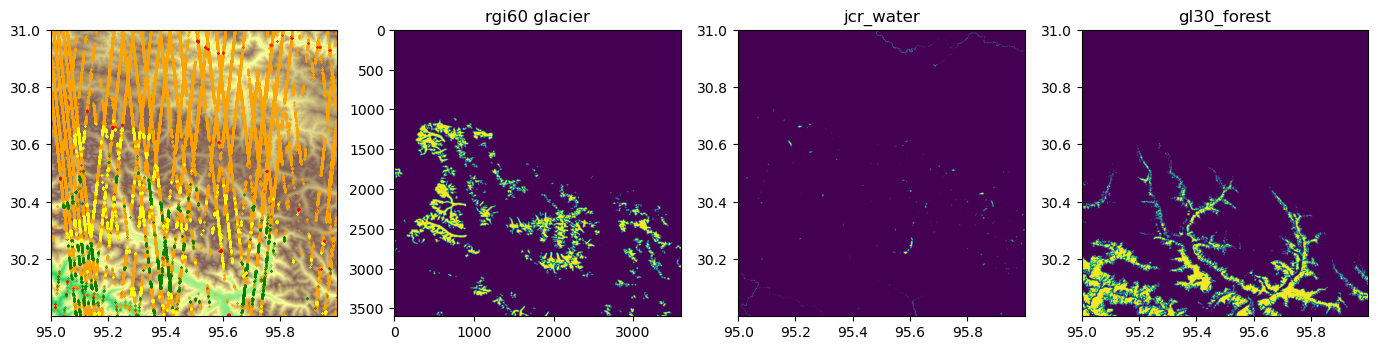

In [55]:
### Check the icesat2 data of different land cover types.
ids_stable = np.where(isat['type_fp']==0)[0] 
ids_wat = np.where(isat['type_fp']==1)[0] 
ids_forest = np.where(isat['type_fp']==2)[0] 
ids_glacier = np.where(isat['type_fp']==3)[0] 
plt.figure(figsize=(17,4))
plt.subplot(1,4,1)
plt.imshow(srtm, vmin=0, vmax=7000, extent=srtm_info['geoextent'], cmap='terrain')
plt.scatter(x=isat['lon'][ids_stable], y=isat['lat'][ids_stable], marker='.', c='orange', s=0.2, zorder=0)
plt.scatter(x=isat['lon'][ids_wat], y=isat['lat'][ids_wat], marker='.',c='red', s=0.2, zorder=0)
plt.scatter(x=isat['lon'][ids_forest], y=isat['lat'][ids_forest], marker='.', c='green', s=0.2, zorder=0)
plt.scatter(x=isat['lon'][ids_glacier], y=isat['lat'][ids_glacier], marker='.', c='yellow', s=0.2, zorder=0)
plt.subplot(1,4,2); plt.imshow(mask_glacier)
plt.title('rgi60 glacier')
plt.subplot(1,4,3); plt.imshow(mask_wat, extent=srtm_info['geoextent'])
plt.title('jcr_water')
plt.subplot(1,4,4); plt.imshow(mask_forest, extent=srtm_info['geoextent'])
plt.title('gl30_forest')


### 1. Elevation difference on the glacier area.

In [56]:
## Select the icesat2 data which on the glacier area.
isat_glacier = {}
for key in isat:
  isat_glacier[key] = isat[key][isat['type_fp']==3]
h_glacier_isat = isat_glacier['h']
h_glacier_isat.shape


(17468,)

In [57]:
row_isat_gla_srtm, col_isat_gla_srtm = geo2imagexy(x=isat_glacier['lon'], y=isat_glacier['lat'], gdal_trans=srtm_info['geotrans'], integer=True)
h_glacier_srtm = srtm[row_isat_gla_srtm, col_isat_gla_srtm]
h_glacier_dif = h_glacier_isat - h_glacier_srtm
h_glacier_dif


array([10.287109 , 25.198242 , 12.852051 , ..., -4.0512695, -3.209961 ,
       -7.3496094], dtype=float32)

In [58]:
h_glacier_dif_bins = {}
h_glacier_dif[np.abs(h_glacier_dif)>150]=np.nan  ## Remove the icesat data which the elevation difference lager than 150 m.
bin_start, bin_end = np.floor(np.min(h_glacier_srtm)/100)*100, np.ceil(np.max(h_glacier_srtm)/100)*100
num_bin = ((bin_end - bin_start)/100).astype(int)
for i in range(num_bin):
  start, end = bin_start + i*100,  bin_start + i*100 + 100
  ids_bin = np.where((h_glacier_srtm < end) & (h_glacier_srtm > start))[0]
  h_glacier_dif_bins[str(start.astype(int))+'-'+str(end.astype(int))] = h_glacier_dif[ids_bin]
print(h_glacier_dif_bins.keys())


dict_keys(['3300-3400', '3400-3500', '3500-3600', '3600-3700', '3700-3800', '3800-3900', '3900-4000', '4000-4100', '4100-4200', '4200-4300', '4300-4400', '4400-4500', '4500-4600', '4600-4700', '4700-4800', '4800-4900', '4900-5000', '5000-5100', '5100-5200', '5200-5300', '5300-5400', '5400-5500', '5500-5600', '5600-5700', '5700-5800', '5800-5900', '5900-6000', '6000-6100', '6100-6200', '6200-6300'])


### Height difference values filter by using 2*sigma threshold

In [59]:
### remove the outlier values
h_glacier_dif_mean = np.nanmean(h_glacier_dif)
h_glacier_dif_sigma = np.nanstd(h_glacier_dif)
h_glacier_dif_filter = h_glacier_dif
h_glacier_dif_filter[np.abs(h_glacier_dif - h_glacier_dif_mean) > 3*h_glacier_dif_sigma]=np.nan
print('mean:', h_glacier_dif_mean)
print('standard deviation:', h_glacier_dif_sigma)


mean: -12.726135
standard deviation: 18.298006


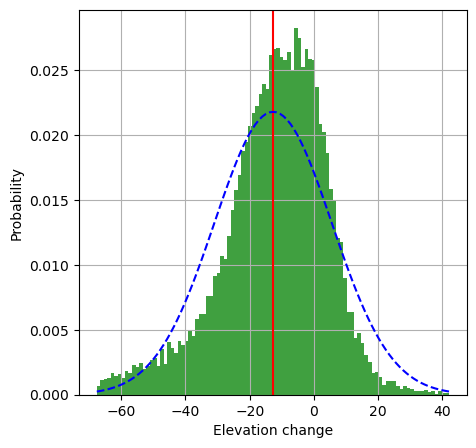

In [60]:
## The histogram of the data
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(h_glacier_dif_filter, bins=100, density=True, facecolor='g', alpha=0.75)
plt.axvline(x=h_glacier_dif_mean, color='r')
y = ((1 / (np.sqrt(2 * np.pi) * h_glacier_dif_sigma)) *
     np.exp(-0.5 * (1 / h_glacier_dif_sigma * (bins - h_glacier_dif_mean))**2))
plt.plot(bins, y, 'b--')
plt.xlabel('Elevation change')
plt.ylabel('Probability')
plt.grid(True)


### 2. Elevation difference on the non-glacier stable area (exclude water, forest, and shrub coverage).

In [61]:
## Extract the icesat data which on the stale area.
isat_stable = {}
for key in isat:
  isat_stable[key] = isat[key][isat['type_fp']==0]
h_stable_isat = isat_stable['h']
h_stable_isat.shape


(246913,)

In [62]:
## Extract the srtm data which on the stable area
row_isat_stable_srtm, col_isat_stable_srtm = geo2imagexy(x=isat_stable['lon'], y=isat_stable['lat'], gdal_trans=srtm_info['geotrans'], integer=True)
h_stable_srtm = srtm[row_isat_stable_srtm, col_isat_stable_srtm]
h_stable_dif = h_stable_isat - h_stable_srtm 


In [63]:
### elevation difference calculation
h_stable_dif[np.abs(h_stable_dif)>50]=np.nan  ## remove the icesat data which the elevation difference lager than 150 m.
h_stable_dif

array([ 5.7612305 , 20.595703  , -0.33398438, ...,  1.4074707 ,
       -1.4299316 , -2.9384766 ], dtype=float32)

In [64]:
### remove the outlier values
h_stable_dif_mean = np.nanmean(h_stable_dif)
h_stable_dif_sigma = np.nanstd(h_stable_dif)
h_stable_dif_filter = h_stable_dif
h_stable_dif_filter[np.abs(h_stable_dif - h_stable_dif_mean) > 3*h_stable_dif_sigma]=np.nan
print('mean:', h_stable_dif_mean)
print('standard deviation:', h_stable_dif_sigma)


mean: -2.6775658
standard deviation: 10.41854


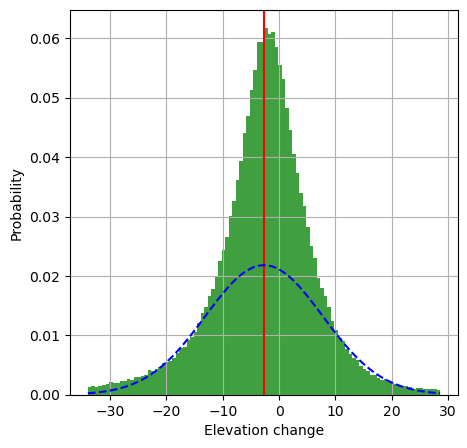

In [65]:
## The histogram of the data
plt.figure(figsize=(5,5))
n, bins, patches = plt.hist(h_stable_dif_filter, bins=100, density=True, facecolor='g', alpha=0.75)
plt.axvline(x=h_stable_dif_mean, color='r')
y = ((1 / (np.sqrt(2 * np.pi) * h_glacier_dif_sigma)) *
     np.exp(-0.5 * (1 / h_stable_dif_sigma * (bins - h_stable_dif_mean))**2))
plt.plot(bins, y, 'b--')
plt.xlabel('Elevation change')
plt.ylabel('Probability')
plt.grid(True)
